# PATATO: A Python Photoacoustic Tomography Analysis Toolkit

In [8]:
import patato as pat
from patato.data import get_msot_time_series_example, get_msot_phantom_example
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from patato.useful_utilities import add_subfigure_label
import matplotlib

sns.set_context("paper", font_scale=8/9.6)
matplotlib.rcParams['font.sans-serif'] = ["Arial"]
matplotlib.rcParams['figure.labelsize'] = "medium"
matplotlib.rcParams['figure.titlesize'] = "medium"
matplotlib.rcParams['figure.titleweight'] = "bold"
matplotlib.rcParams['axes.titlesize'] = "medium"
matplotlib.rcParams['axes.titleweight'] = "normal"
matplotlib.rcParams['axes.labelweight'] = "bold"
matplotlib.rcParams['figure.labelweight'] = "bold"
matplotlib.rcParams['figure.constrained_layout.use'] = True

matplotlib.rcParams['figure.constrained_layout.h_pad'] = 0.01
matplotlib.rcParams['figure.constrained_layout.w_pad'] = 0.04
matplotlib.rcParams['figure.constrained_layout.hspace'] = 0.00
matplotlib.rcParams['figure.constrained_layout.wspace'] = 0.00

In [3]:
pa_so2 = get_msot_time_series_example("so2")
pa_dce = get_msot_time_series_example("icg") # We'll get the ROIs from here.
pa_so2.set_default_recon(("Reference Backprojection", "0"))
pa_dce.set_default_recon(("Reference Backprojection", "0"))
pa_dce.default_unmixing_type = "ICG"
pa_dce.external_roi_interface = pa_so2

# Get the oe reconstructions, so2 and delta icgs:
rec = pa_so2.get_scan_reconstructions()
so2 = pa_so2.get_scan_so2()

thb = pa_so2.get_scan_thb()

icg = pa_dce.get_scan_unmixed()[:, 2:] # ICG is the 3rd dataset in the unmixed data.

times = pa_so2.get_timestamps()[:, 0]
times -= times[0]
times /= 60

icg_times = pa_dce.get_timestamps()[:, 0]
icg_times -= icg_times[0]
icg_times /= 60

roi_tumour_right = pa_so2.get_rois()["tumour_right", "0"]
roi_tumour_left = pa_so2.get_rois()["tumour_left", "0"]
roi_reference = pa_so2.get_rois()["reference_", "0"]

/home/cri.camres.org/else01/patato/patato/core/image_structures/reconstruction_image.py:43: UserWarning: Old version of PATATO used to generate this data. We recommend to re-run the image reconstruction.
  warnings.warn("Old version of PATATO used to generate this data. We recommend to re-run the image reconstruction.")
/home/cri.camres.org/else01/patato/patato/core/image_structures/reconstruction_image.py:43: UserWarning: Old version of PATATO used to generate this data. We recommend to re-run the image reconstruction.
  warnings.warn("Old version of PATATO used to generate this data. We recommend to re-run the image reconstruction.")
/home/cri.camres.org/else01/patato/patato/core/image_structures/reconstruction_image.py:43: UserWarning: Old version of PATATO used to generate this data. We recommend to re-run the image reconstruction.
  warnings.warn("Old version of PATATO used to generate this data. We recommend to re-run the image reconstruction.")
/home/cri.camres.org/else01/patato

In [4]:
def get_trace(time_series_data, region, filter_bad=False):
    mask, _ = region.to_mask_slice(time_series_data)
    timeseries = time_series_data.raw_data.T[mask.T].T[:, 0, :]
    # Unmixed SO2 can be out of the interval [0, 1] when there is low SNR.
    if filter_bad:
        timeseries[(timeseries>1) | (timeseries<0)] = np.nan
    return np.nanmean(timeseries, axis=-1)

def get_pixel_values(delta_values, region, filter_bad=False):
    mask, _ = region.to_mask_slice(delta_values)
    delta = delta_values.raw_data.T[mask.T].T

    if filter_bad:
        delta[(delta>0.1) | (delta<-0.1)] = np.nan
    return delta

gca = pat.GasChallengeAnalyser(display_output=False)
dso2, _, (baseline_so2, baseline_sigma_so2) = gca.run(so2, pa_so2)

dce = pat.DCEAnalyser(display_output=False)
dicg, _, [baseline_icg, baseline_sigma_icg] = dce.run(pa_dce.get_scan_unmixed(), pa_dce)

/home/cri.camres.org/else01/patato/patato/core/image_structures/reconstruction_image.py:43: UserWarning: Old version of PATATO used to generate this data. We recommend to re-run the image reconstruction.
  warnings.warn("Old version of PATATO used to generate this data. We recommend to re-run the image reconstruction.")


In [5]:
pa_so2.get_wavelengths()

array([700., 730., 750., 760., 770., 800., 820., 840., 850., 880.])

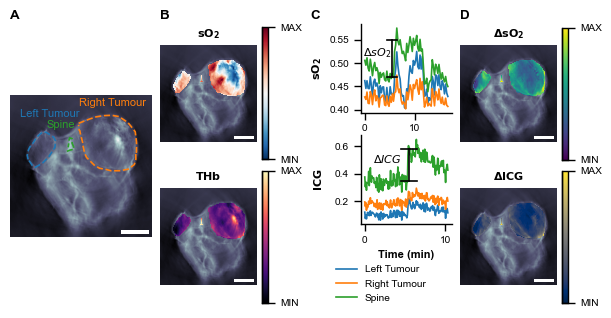

In [15]:
icg_df = pd.DataFrame({"times": np.concatenate([icg_times] * 3), 
                       "ICG": np.concatenate([get_trace(icg, r) for r in [roi_reference, roi_tumour_right, roi_tumour_left]]),
                       "Region": ["Spine"] * len(icg_times) + ["Right Tumour"] * len(icg_times) + ["Left Tumour"] * len(icg_times)
                      })


so2_df = pd.DataFrame({"times": np.concatenate([times] * 3), 
                       "SO2": np.concatenate([get_trace(so2, r, True) for r in [roi_reference, roi_tumour_right, roi_tumour_left]]),
                       "Region": ["Spine"] * len(times) + ["Right Tumour"] * len(times) + ["Left Tumour"] * len(times)
                      })



fig = plt.figure(figsize=(6, 3))
subfigs = fig.subfigures(1, 4)

colours = {"Left Tumour": "C0", 
           "Right Tumour": "C1",
           "Spine": "C2"
          }

dxy = {"Left Tumour": (-5, 22),
       "Right Tumour": (0, 26),
       "Spine": (-15, 12)
      }

ax = subfigs[0].subplots()
rec.imshow(ax=ax, scale_kwargs={"fixed_value": 0.005,
                                                "scale_loc": "none",
                                                "width_fraction": 0.025,
                                               })
for r,n in zip([roi_reference, roi_tumour_right, roi_tumour_left],
             ["Spine", "Right Tumour", "Left Tumour"]
            ):
    ax.plot(*r.points.T, color=colours[n], linestyle="--", label=n)
    x = np.min(r.points[:, 0])
    y = np.mean(r.points[:, 1])
    dx, dy = dxy[n]
    ax.annotate(n, (x, y), (dx, dy), 
                textcoords="offset points", 
                ha="right" if x > 0 else "left", 
                color=colours[n]
               )

axes = subfigs[3].subplots(2)
im_recon = rec.imshow(ax=axes[0], scale_kwargs={"fixed_value": 0.005,
                                                "scale_loc": "none",
                                                "width_fraction": 0.025,
                                               })
im_dso2 = dso2.imshow(roi_mask=[roi_reference, roi_tumour_right, roi_tumour_left], 
                      ax=axes[0], scalebar=False)
# axes[0].set_title(r"$\mathbf{\Delta sO_2}$")
cbar1 = plt.colorbar(im_dso2, ax=axes[0])
cbar1.ax.set_yticks(list(im_dso2.get_clim()), ["MIN", "MAX"])
axes[0].set_title(r"$\mathbf{\Delta sO_2}$")
im_recon = rec.imshow(ax=axes[1], scale_kwargs={"fixed_value": 0.005,
                                                "scale_loc": "none",
                                                "width_fraction": 0.025,
                                               })
im_dicg = dicg.imshow(roi_mask=[roi_reference, roi_tumour_right, roi_tumour_left], 
                      ax=axes[1], scalebar=False)
# axes[1].set_title(r"$\mathbf{\Delta ICG}$")
cbar2 = plt.colorbar(im_dicg, ax=axes[1])
cbar2.set_ticks([])
axes[1].set_title(r"$\mathbf{\Delta ICG}$")
cbar2.ax.set_yticks(list(im_dicg.get_clim()), ["MIN", "MAX"])
subfigs[3].align_ylabels([cbar1.ax, cbar2.ax])

axes = subfigs[1].subplots(2)
im_recon = rec.imshow(ax=axes[0], scale_kwargs={"fixed_value": 0.005,
                                                "scale_loc": "none",
                                                "width_fraction": 0.025,
                                               })
im_dso2 = baseline_so2.imshow(roi_mask=[roi_reference, roi_tumour_right, roi_tumour_left], 
                      ax=axes[0], scalebar=False)
cbar1 = plt.colorbar(im_dso2, ax=axes[0])
axes[0].set_title(r"$\mathbf{sO_2}$")
cbar1.ax.set_yticks(list(im_dso2.get_clim()), ["MIN", "MAX"])
im_recon = rec.imshow(ax=axes[1], scale_kwargs={"fixed_value": 0.005,
                                                "scale_loc": "none",
                                                "width_fraction": 0.025,
                                               })
im_dicg = thb.imshow(roi_mask=[roi_reference, roi_tumour_right, roi_tumour_left], 
                      ax=axes[1], scalebar=False)
cbar2 = plt.colorbar(im_dicg, ax=axes[1])
axes[1].set_title(r"$\mathbf{THb}$")
cbar2.ax.set_yticks(list(im_dicg.get_clim()), ["MIN", "MAX"])

subfigs[1].align_ylabels([cbar1.ax, cbar2.ax])
# axes[1].set_title("$\mathbf{ICG}$")

axes = subfigs[2].subplots(2)
for n, g in so2_df.groupby("Region"):
    axes[0].plot(g["times"], g["SO2"], color=colours[n], label=n)
    if n=="Spine":
        axes[0].plot([4.5, 6.5], [0.47, 0.47], c="k")
        axes[0].plot([4.5, 6.5], [0.55, 0.55], c="k")
        axes[0].plot([5.5, 5.5], [0.47, 0.55], c="k")
        axes[0].annotate(r"$\Delta sO_2$", (5.5, (0.55+0.47)/2), (-1, 4), 
                         textcoords="offset points", va="center", ha="right")
# axes[0].set_xlabel("Time (min)")
axes[0].set_ylabel(r"$\mathbf{sO_2}$")
for n, g in icg_df.groupby("Region"):
    axes[1].plot(g["times"], g["ICG"], color=colours[n])
    if n=="Spine":
        axes[1].plot([4.5, 6.5], [0.35, 0.35], c="k")
        axes[1].plot([4.5, 6.5], [0.58, 0.58], c="k")
        axes[1].plot([5.5, 5.5], [0.35, 0.58], c="k")
        axes[1].annotate(r"$\Delta ICG$", (5.5, (0.58+0.35)/2), (-5, 4), 
                         textcoords="offset points", va="center", ha="right")
    
axes[1].set_xlabel("Time (min)")
axes[1].set_ylabel(r"$\mathbf{ICG}$")

subfigs[2].legend(*axes[0].get_legend_handles_labels(), loc="outside lower center", 
                  frameon=False, borderaxespad=.2)

# subfigs[0].suptitle("Regions of\nInterest", fontsize="x-large")
# subfigs[1].suptitle("Spectral Unmixing", fontsize="x-large")
# subfigs[2].suptitle("Temporal Data", fontsize="x-large")
# subfigs[3].suptitle("Temporal Analysis", fontsize="x-large")

add_subfigure_label(subfigs[0], subfigs[0].axes[0], "A")
add_subfigure_label(subfigs[1], subfigs[1].axes[0], "B")
add_subfigure_label(subfigs[2], subfigs[2].axes[0], "C")
add_subfigure_label(subfigs[3], subfigs[3].axes[0], "D")

subfigs[2].align_labels()
sns.despine()

fig.savefig("figure_draft.png", dpi=300)
fig.savefig("/Users/else01/Dropbox/figure_transfer/joss_figure_draft.png", dpi=300)
# subfigs[2].set_facecolor("red")
plt.show()

In [97]:
dso2_array = im_dso2.get_array().data
iqr = np.nanpercentile(dso2_array, 75) - np.nanpercentile(dso2_array, 25)
med = np.nanmedian(dso2_array)
dso2_array[dso2_array > med + 3 * iqr] = np.nan
dso2_array[dso2_array < med - 3 * iqr] = np.nan

dicg_array = im_dicg.get_array().data
iqr = np.nanpercentile(dicg_array, 75) - np.nanpercentile(dicg_array, 25)
med = np.nanmedian(dicg_array)
dicg_array[dicg_array > med + 6 * iqr] = np.nan
dicg_array[dicg_array < med - 6 * iqr] = np.nan

rec_array = im_recon.get_array().data

In [7]:
dicgs = [get_pixel_values(dicg, r) for r in [roi_reference, roi_tumour_right, roi_tumour_left]]
dso2s = [get_pixel_values(dso2, r, True) for r in [roi_reference, roi_tumour_right, roi_tumour_left]]

compare_df = pd.DataFrame({"dicg": np.concatenate(dicgs), 
                           "dso2": np.concatenate(dso2s),
                           "Region": sum([[s] * len(j) for s, j in zip(["Reference", "Right Tumour", "Left Tumour"], dso2s)], start=[])
                      })

compare_df

,dicg,dso2,Region
0,0.311121,0.060318,Reference
1,0.342048,0.066264,Reference
2,0.303935,0.055998,Reference
3,0.379399,0.078032,Reference
4,0.415269,0.081478,Reference
...,...,...,...
1950,0.248291,0.049637,Left Tumour
1951,0.159100,0.032974,Left Tumour
1952,0.190295,0.036675,Left Tumour
1953,0.216423,0.043448,Left Tumour
